# 1. Frame the problem
Given a picture of a random English cursive letter, determine which letter the picture depicts. (Ex. A short loop generally depicts an e, while a tall loop depicts an l.)

# 2. Get the Data 
- The data was initially provided in a google drive zip folder called "2023 Cursive".
- To initially load the data, I downloaded the zip file onto my local machine, and then utilized the Jupyter upload feature to upload the zip file to the remote server.
- After the zip file was fully uploaded, I unzipped the file using the unzip package, renaming the outputted folder to 2023_Cursive for simplicity. Inside the new folder there were 9 zip files, each labelled 1 to 9."
- I unzipped each folder individually using the unzip package. Each time I would unzip a folder, its name would change to what the student originally called it, so I would rename the newly created folder back to the number of its corresponding zip file. This was to keep the files/folders organized, also preventing files from mixing since some of the original folder names are identical. (Ex. Unzipping "1.zip" outputs a folder called "Cursive letters", so I renamed that folder to just "1".)
- Finally, after unzipping everything, I deleted all the zip files by running "rm *.zip -r" in the "2023_Cursive" folder, leaving only the newly unzipped folders.

# 3. Explore the Data

#### Below is a function that makes it easier to view images in the IPYNB. It is used for everything, so make sure to run it after any kernel restart.

In [2]:
def show(img_obj): #made this since pyplot only shows the correct color if u convert to rgb but everything in opencv is done in bgr so yea also this just helps with keeping code clean and non repeating
    plt.imshow(cv2.cvtColor(img_obj, cv2.COLOR_BGR2RGB))
    plt.show()

#### Below is a data explorer that just allows you to look at any image you want by simply typing a 2 character string: the number of the folder, and the letter. Alternatively, typing a single number or letter will show you the corresponding folder or all pictures of the corresponding letters.
- (Ex. "1a" will show you the picture of the letter "a" in folder 1. "a" will show you all pictures of the letter "a" across all 9 folders, and "1" will show you all pictures in folder 1.)

Folder and Letter: a


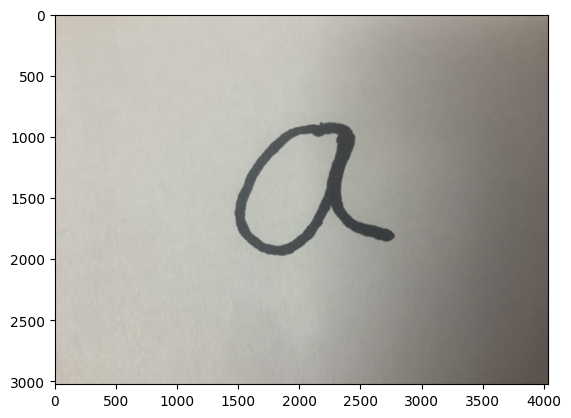

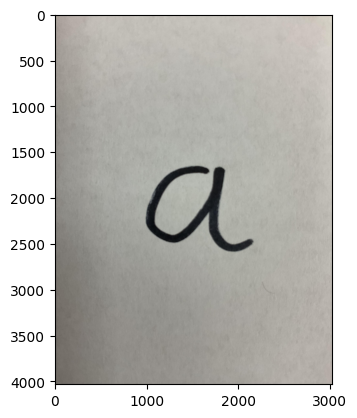

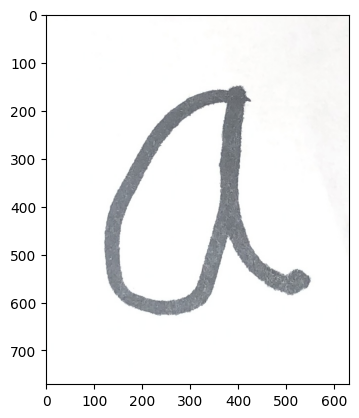

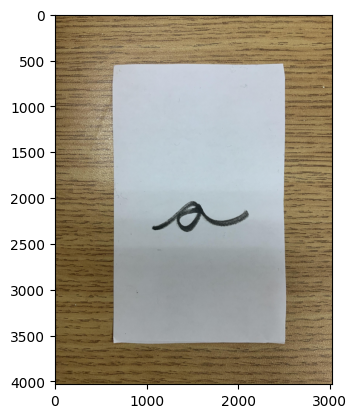

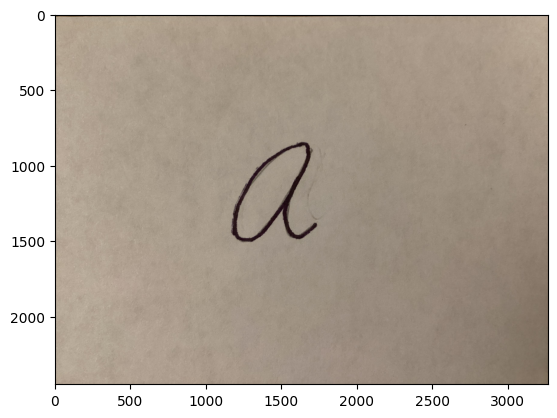

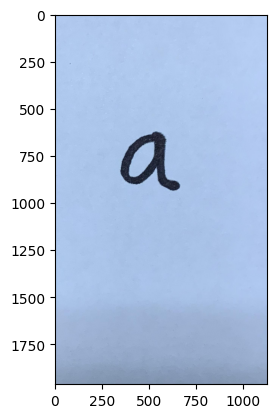

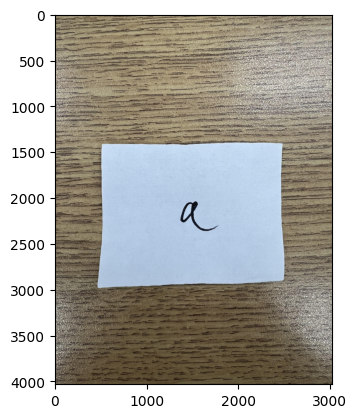

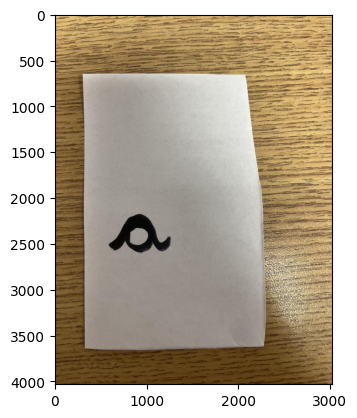

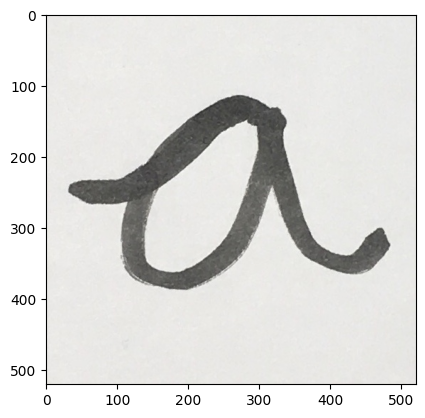

Folder and Letter:  


In [4]:
import cv2
from matplotlib import pyplot as plt
from IPython.display import clear_output #so that output is cleared after every page to prevent clutter and huge outputs

#search thing to see any image without having to look for it in files
set = "2023_Cursive/"
# set = "2023_Cursive_Cleaned/" #comment this out if you want to see the original images
while True:
    uinput = input("Folder and Letter: ") #ex. "2a" to see folder 2, letter a. SPECIAL FEATURE: to see all images of a certain letter, do "s" + the letter you want to view, and it will show all letters.
    if len(uinput) != 1 and len(uinput) != 2:
        break
    clear_output()
    print("Folder and Letter: " + uinput)
    if len(uinput) == 1:
        try:
            for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
                image = cv2.imread(set + str(int(uinput)) + "/" + letter + ".JPG")
                show(image)
        except:
            for i in range (1,10):
                image = cv2.imread(set + str(i) + "/" + uinput[0].upper() + ".JPG")
                show(image)
    elif len(uinput) == 2:
        image = cv2.imread(set + uinput[0] + "/" + uinput[1].upper() + ".JPG")
        show(image)

# 4. Prepare the Data
#### Some data prep was done during the unzipping process in step 2 to ensure the files and folders all remained organized and consistent enough to be exploreable (see step 2 for details).
#### The files themselves were still messy though, so some data prep had to be done between steps 2 and 3 in preparation for data exploration.
#### Since this data prep wasn't addressed between the 2 steps, all the issues fixed between steps 2 and 3 are listed below (in the same order they were resolved) and their solutions are provided:
- Folders 2 and 6 had several images with no file extensions.
    - To fix this, I created a short program (located in the same folder as this IPYNB) called rename.py. I moved this program into the folders with this issue, and upon running it, it would add ".HEIC" to the end of each file name in the folder (I also made sure to check beforehand that all files with this issue were HEIC images, so there was no need to distinguish between different file types, making the program very simple yet effective).
- Folder 8 had three versions of every image, two versions being unnamed.
    - To fix this, I just ran the command "rm IMG* -r" in the problematic directory which removed all files beginning with "IMG". This left only the files that were properly named.
- Only folders 3, 7, and 9 contained their images in a JPG format. The rest of the folders all contained HEIC images, which are unsupported by OpenCV and most other image processing libraries.
    - To fix this, I created a program (located in the same folder as this IPYNB) called convert.py. Upon being run, this program loops through every single image in the provided dataset. If an image is HEIC, it is converted into JPG. Also, for the sake of consistency, all file names are converted to uppercase so that all file names are the exact same for each set of cursive letters.
###### _At this point, I might as well just do step 4 before step 3 every time since data prep always happens there..._
#### Finally, we return to where we are now, step 4. This step took me no joke, over 10 hours of work to complete.
- Now arises a much more difficult issue to deal with: standardizing the images themselves.
- Of course, to do this, I loop through every image and deal with it individually, not doing anything by hand, meaning I am not using external knowledge of the file's group to know what transformations need to be done.
#### Part 1: Cropping
- So before trying to isolate the letters themselves, I focused specifically on the image sets (4, 7, and 8) that did not have cropped letters and made an algorithm to detect if an image is not cropped and then crop it properly (of course not applying specific transformations).
- A lot of testing and tweaking was done, but in the end I settled on this:
    1. Gray, blur, and treshold the image.
    2. Detect edges and then detect lines from edges. Isolate all lines that are nearly vertical or nearly horizontal, and seperate them into 2 lists. (If no lines are detected, assume the image is cropped and move on)
    3. Compare the lines in each list to find all intersection points (slope based, meaning the lines do not have to be touching as long as the slopes would eventually collide)
    4. Pick an intersection point from each quadrant of the image to use as corners, and do a slight offset to ensure that there is no (or in rare cases minimal) table still showing (If one or more corners are missing, assume the image is cropped and move on)
    5. Do a perspective transform to finally get the cropped image, and pass it into the function which deals with the second step
- Lots of tweaking had to be done due to issues with not all corners being detected, but in the end it works on all 3 non cropped data sets.
#### Part 2: Isolating Letter
- Now that the images are _almost_ (as will be addressed soon) all perfectly cropped, now I have to isolate the letter itself to make a 1:1 aspect ratio image with the letter being a (mostly) standard size.
- This step was done entirely in a function so it could be called at different points because there are situations where you don't need to crop before doing this step, meaning you would want to begin this earlier.
- This took immense amounts of tests, but it works well enough despite a few inpurities, so here is the process:
    1. The grayed, cropped image is to be passed in (so either just a gray version of the original image or a grayed version of the perspective transformed image depending on what happened in the previous step)
    2. The image is blurred, edge detected, binarized from the canny image, and then dilated so that it's easier to spot the letter outlines that are created
    3. Using mins and maxes on np arrays, the highest, lowest, left most, and right most black pixels are found and saved.
        - But for this step, remember how some images have a slight amount of table still showing? If the black pixels are too close to the edge, the image is slightly cropped to remove possible missed bits, which solves the issue in all known cases. Of course, the updated black pixel extremes are found.
    4. Then, a square region is found around the letter to be cropped to. The image is cropped to this region. Sometimes, if an edge is hit, it won't be a square, which will cause a stretch in the final resize, but it's nothing significant enough to distort the letter in a bad way.
    5. The image is binarized.
        - This step has multiple steps inside it and took a lot of tweaking to get right:
        1. The cropped image is blurred.
        2. All pixels >= 235 are thresholded to 255 to prevent artifacts in the next step (remember, the image is grayscale)
        3. This is what really allows the image to be binarized correctly even though adaptiveThreshold sucks: the histogram of grayscale scalars in the image is equalized, so even if the handwriting is a light gray due to flash or other reasons, it will still binarize correctly.
        4. The final binarization threshold is applied, with the threshold being a scalar of the average pixel value of the image (this part is what causes the most problems as some letters get some parts thresholded out since this isn't perfect, but then again adaptiveThreshold would only draw outlines which prevented me from using it so I had to do these workarounds)
    6. Finally, the image is downscaled to 50x50 pixels and saved to a new folder which contains all of these newly cropped images.
### Finally, the data prep is done! That was just data prep!
All the cleaning code is in the cell below.

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import copy
import math
import os




def isolateLetter(gcroppedimage):
        
    cheight = gcroppedimage.shape[0]
    cwidth = gcroppedimage.shape[1]
    
    bcroppedimage = cv2.medianBlur(gcroppedimage,65) #warped image blurred the same way the og image is blurred

    cedges = cv2.Canny(bcroppedimage, 30, 50)
    show(cedges)
    
    bincroppedimage = cv2.threshold(cedges, 140, 255, cv2.THRESH_BINARY)[1] #binarized
    show(bincroppedimage)

    kernel = np.ones((5,5), np.uint8)
    dilcroppedimage = cv2.dilate(bincroppedimage, kernel, iterations=1)

    invbinimage = cv2.bitwise_not(binimage) #invert img to work
    
    # zeros = np.transpose(np.nonzero(invbinimage)) #array of all nonzero value indexes (except since its inverted its actually the zero values)
    zeros = np.transpose(np.nonzero(dilcroppedimage))
    show(dilcroppedimage)

    if np.min(zeros, axis=0)[0] < cheight/20 or np.max(zeros, axis=0)[0] > cheight-cheight/20 or np.min(zeros, axis=0, keepdims=True)[0][1] < cwidth/20 or np.max(zeros, axis=0, keepdims=True)[0][1] > cwidth-cwidth/20:
        dilcroppedimage = dilcroppedimage[int(cheight/20):int(cheight-cheight/20), int(cwidth/20):int(cwidth-cwidth/20)]
        gcroppedimage = gcroppedimage[int(cheight/20):int(cheight-cheight/20), int(cwidth/20):int(cwidth-cwidth/20)]
        zeros = np.transpose(np.nonzero(dilcroppedimage))
        print("cropped due to minor uncropped area")
        show(dilcroppedimage)

    cheight = gcroppedimage.shape[0]
    cwidth = gcroppedimage.shape[1]

    
    letterTop = np.min(zeros, axis=0)[0]
    letterBottom = np.max(zeros, axis=0)[0]
    letterLeft = np.min(zeros, axis=0, keepdims=True)[0][1]
    letterRight = np.max(zeros, axis=0, keepdims=True)[0][1]

    

    letterHeight = letterBottom-letterTop
    letterWidth = letterRight-letterLeft
    # print("letter height: " + str(letterHeight))
    # print("letter width: " + str(letterWidth))

    
    if letterHeight > letterWidth:
        # print("height bigger")
        letterBottom += cwidth/10
        letterTop -= cwidth/10
        newLetterHeight = letterBottom-letterTop
        letterLeft -= (newLetterHeight-letterWidth)/2
        letterRight += (newLetterHeight-letterWidth)/2
    
    elif letterHeight < letterWidth:
        # print("width bigger")
        letterLeft -= cwidth/10
        letterRight += cwidth/10
        newLetterWidth = letterRight-letterLeft
        letterTop -= (newLetterWidth-letterHeight)/2
        letterBottom += (newLetterWidth-letterHeight)/2
        
    else:
        # print("height = width (damn)")
        letterBottom += cwidth/10
        letterTop -= cwidth/10
        letterLeft -= cwidth/10
        letterRight += cwidth/10

    letterBottom = max(0, letterBottom)
    letterTop = max(0, letterTop)
    letterLeft = max(0, letterLeft)
    letterRight = max(0, letterRight)
    
    # print("new letter height: " + str(letterBottom-letterTop))
    # print("new letter width: " + str(letterRight-letterLeft))

    # print("letterLeft: " + str(int(letterLeft)))
    # print("letterRight: " + str(int(letterRight)))
    # print("letterTop: " + str(int(letterTop)))
    # print("letterBottom: " + str(int(letterBottom)))

    
    letterimage = gcroppedimage[int(letterTop):int(letterBottom), int(letterLeft):int(letterRight)]
    show(letterimage)



    bletterimage = cv2.medianBlur(letterimage,51)

    #basically what happens below is i change all values pretty close to 255 to 255 to prevent artifacts when doing the hist equalize
    bletterimage = cv2.bitwise_not(bletterimage)
    bletterimage = cv2.threshold(bletterimage, 40, 255, cv2.THRESH_TOZERO)[1]
    bletterimage = cv2.bitwise_not(bletterimage)
    show(bletterimage)


    contrastletterimage = cv2.equalizeHist(bletterimage)
    
    show(contrastletterimage)
    
    # thresh = np.average(contrastletterimage)*0.5
    thresh = np.average(contrastletterimage)*0.75 #0.8 works well
    # thresh = 0
    # print(thresh)

    binletterimage = cv2.threshold(bletterimage, int(thresh), 255, cv2.THRESH_BINARY)[1] # + cv2.THRESH_OTSU
    show(binletterimage)
    
    finalletterimage = cv2.resize(binletterimage, (50, 50))
    show(finalletterimage)

    return finalletterimage








for folder in "7":
# for folder in sorted(os.listdir("2023_Cursive")): #iterate over every folder
    for letter in "S":
    # for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
        
        image = cv2.imread("2023_Cursive/" + folder + "/" + letter + ".JPG") #bgr to rgb is req for correct colors to show
        show(image)

        #get height and width which end up being used a decent amount for calculating stuff
        height = image.shape[0]
        width = image.shape[1]
        
        gimage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #make img gray
        
        bimage = cv2.medianBlur(gimage,99) #blur using median which gives everything a very smoothed out look which helps a lot with stuff like edge detection #too high blur can cause edge detections problems
        show(bimage)
        
        binimage = cv2.adaptiveThreshold(bimage, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 1) #binarize the image,
        show(binimage)


        # kernel = np.ones((15,15), np.uint8)
        # erobinimage = cv2.erode(binimage, kernel, iterations=1)
        # show(erobinimage)

        edges = cv2.Canny(binimage, 50, 100) #find edges
        show(edges)
        
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180,110, minLineLength=width*0.5, maxLineGap=height) #find lines from edges
        lineimage = copy.copy(image) #make copy of image specifically for drawing lines and stuff because the original image will be used for cropping and saving later

        #make lists that will hold all vertical and horizontal lines
        vertical = []
        horizontal = []

        try:
            for line in lines:
                for x1,y1,x2,y2 in line: #goes thru every detected line ofc
                    if (x2-x1) != 0: #prevent division by 0 problems
                        slope = (y2-y1)/(x2-x1) 
                    else:
                        slope = (y2-y1)/1 #close enough to a vertical slope
                    
                    if slope > (height/(width*0.2)) or slope < (-height/(width*0.2)): #filters for vertical lines
                        vertical.append((x1,y1,x2,y2)) #adds vertical line to list
                        cv2.line(lineimage,(x1,y1),(x2,y2),(255,0,0),int(width/100)) #vertical lines are blue
                    elif (slope < ((width*0.2)/height) and slope > ((-width*0.2)/height)): #filters for horizontal lines
                        horizontal.append((x1,y1,x2,y2)) #adds horizontal line to list
                        cv2.line(lineimage,(x1,y1),(x2,y2),(0,255,0),int(width/100)) #horizontal lines are blue
        except:
            #save to cropped folder here
            print("no lines detected, assuming already cropped")
            cv2.imwrite("2023_Cursive_Cleaned/" + folder + "/" + letter + ".JPG", isolateLetter(gimage))
            continue
        
        show(lineimage)


        
        def line_intersection(line1, line2): #function that gets the intersection of 2 lines
            x1, y1 = line1[0]
            x2, y2 = line1[1]
            x3, y3 = line2[0]
            x4, y4 = line2[1]
            if x2 - x1 != 0:
                slope1 = (y2 - y1) / (x2 - x1)
            else:
                slope1 = (y2 - y1) / 1
            if x3 - x4 != 0:    
                slope2 = (y4 - y3) / (x4 - x3)
            else:
                slope2 = (y4 - y3) / 1
        
            intercept1 = y1 - slope1 * x1
            intercept2 = y3 - slope2 * x3

            if slope1 - slope2 != 0:
                intersection_x = (intercept2 - intercept1) / (slope1 - slope2)
            else:
                intersection_x = (intercept2 - intercept1) / 1
            intersection_y = slope1 * intersection_x + intercept1
        
            return (int(intersection_x), int(intersection_y)) #rounded for simplicity and cv2.circle but doesnt really change anything
            

        sects = [] #list that holds coordinates of every single intersection


        for vertLine in vertical: #only test intersections of vertical lines and horizontal lines, dont test every line against every other line because ofc vertical lines will intercept
            for horizLine in horizontal: 
                vx1, vy1, vx2, vy2 = vertLine
                hx1, hy1, hx2, hy2 = horizLine
                sects.append(line_intersection(((vx1,vy1), (vx2,vy2)), ((hx1,hy1), (hx2,hy2)))) #add all intersections to the sect list


        
        sectimage = copy.copy(image)

        tlSect = []
        trSect = []
        blSect = []
        brSect = []
        
        for sect in sects:
            x = sect[0]
            y = sect[1]
            if x < width/2:
                if y < height/2:
                    tlSect.append(sect)
                else:
                    blSect.append(sect)
            else:
                if y < height/2:
                    trSect.append(sect)
                else:
                    brSect.append(sect)


        
        offset = int(width/20)

        try:

            tlBound = tlSect[0]
            tlBound = (tlBound[0]+offset,tlBound[1]+offset)
            cv2.circle(sectimage, tlBound, int(width*0.001), (0,0,255), int(width*0.03))
    
            blBound = blSect[0]
            blBound = (blBound[0]+offset,blBound[1]-offset)
            cv2.circle(sectimage, blBound, int(width*0.001), (255,255,0), int(width*0.03))
    
            trBound = trSect[0]
            trBound = (trBound[0]-offset,trBound[1]+offset)
            cv2.circle(sectimage, trBound, int(width*0.001), (255,0,0), int(width*0.03))
    
            brBound = brSect[0]
            brBound = (brBound[0]-offset,brBound[1]-offset)
            cv2.circle(sectimage, brBound, int(width*0.001), (0,255,0), int(width*0.03))
        except:
            #save to cropped folder here
            print("missing a corner, assuming already cropped")
            cv2.imwrite("2023_Cursive_Cleaned/" + folder + "/" + letter + ".JPG", isolateLetter(gimage))
            continue
        
        show(sectimage)


        
        
        corners = np.array([tlBound, trBound, blBound, brBound], dtype=np.float32) #array with 4 coordinate pairs that are the corners of the paper
        
        res = np.array([(0,0), (brBound[0]-tlBound[0]-1,0), (0,brBound[1]-tlBound[1]-1), (brBound[0]-tlBound[0]-1,brBound[1]-tlBound[1]-1)], dtype=np.float32) #will be 200x200 img
        
        ptransform = cv2.getPerspectiveTransform(corners, res) #calculates matrix
        
        warpimage = cv2.warpPerspective(image, ptransform, (brBound[0]-tlBound[0],brBound[1]-tlBound[1])) #applies matrix to img

        show(warpimage)

        gwarpimage = cv2.cvtColor(warpimage, cv2.COLOR_BGR2GRAY) #warped img becomes gray because function needs gray image to be passed in

        cv2.imwrite("2023_Cursive_Cleaned/" + folder + "/" + letter + ".JPG", isolateLetter(gwarpimage))


NameError: name 'show' is not defined

# 5. Model the data
#### Models to try:
- Multi Layer Perceptron Classifier
- Support Vector Classifier
- K Nearest Neighbors
- Random Forest Classifier

- First, load everything into a dataframe.
- I iterated over every image, flattening each array of pixels (downscaled to 25x25 too for more efficiency)
- I then created a stratified train test split since there should be an even amount of letters for testing and training

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

columnaxis = []

for folder in sorted(os.listdir("2023_Cursive_Cleaned")):
    for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
        
        image = cv2.imread("2023_Cursive_Cleaned/" + folder + "/" + letter + ".JPG", cv2.IMREAD_GRAYSCALE) #bgr to rgb is req for correct colors to show
        image = cv2.resize(image, (25,25)) #decided to resize to 25
        row = [np.array(image).flatten(),letter]
        columnaxis.append(row)
        
dataframe = pd.DataFrame(columnaxis, columns=['Image', 'Label'])

dataframe_X = dataframe['Image']
dataframe_Y = dataframe['Label']

X_train, X_test, Y_train, Y_test = train_test_split(dataframe_X, dataframe_Y, test_size=0.3, random_state=42, stratify=dataframe_Y)
print("done")

done


- Now try 4 different classifer models to see which one gives the best result

#### Multi Layer Perceptron Classifier:

Score: 26.76056338028169


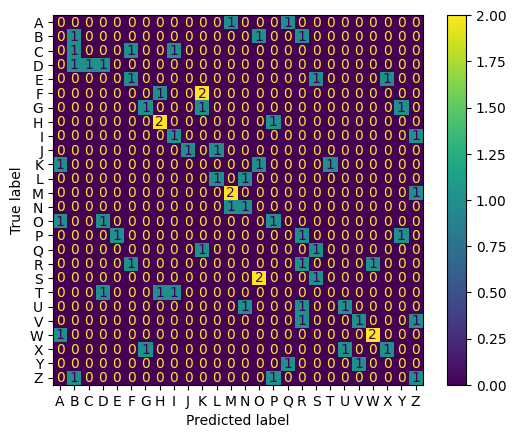

In [3]:
from sklearn import metrics
from sklearn.neural_network import MLPClassifier


mlp_model = MLPClassifier(hidden_layer_sizes=(377,235), max_iter=10000, random_state=42) #hidden layer sizes 50x50/2, 50x50/8
mlp_model.fit(list(X_train), Y_train)
mlp_model_prediction = mlp_model.predict(list(X_test))
print("Score: " + str(metrics.accuracy_score(Y_test, mlp_model_prediction) * 100))

disp = metrics.ConfusionMatrixDisplay.from_predictions(Y_test, mlp_model_prediction)
plt.show()

#### Support Vector Classifier:

Score: 23.943661971830984


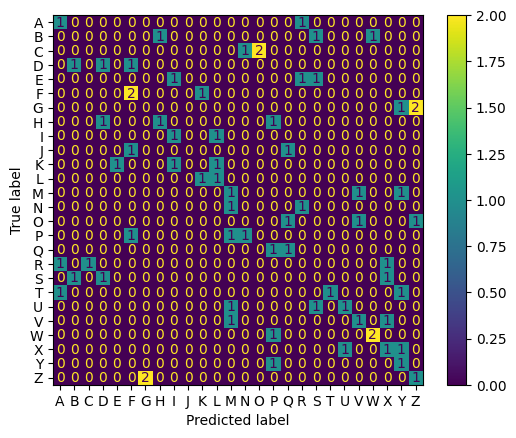

In [7]:
from sklearn.svm import SVC
from sklearn import metrics


svc_model = SVC(kernel='linear')
svc_model.fit(list(X_train), Y_train)
svc_model_prediction = svc_model.predict(list(X_test))
print("Score: " + str(metrics.accuracy_score(Y_test, svc_model_prediction) * 100))

disp = metrics.ConfusionMatrixDisplay.from_predictions(Y_test, svc_model_prediction)
plt.show()

#### K Nearest Neighbors:

Score: 29.577464788732392


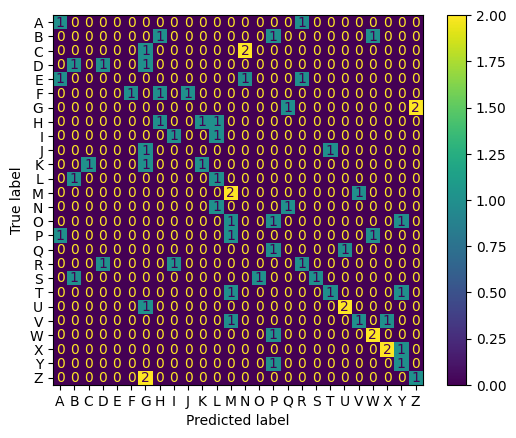

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


knearest_model = KNeighborsClassifier(n_neighbors=1)
knearest_model.fit(list(X_train), Y_train)
knearest_model_prediction = knearest_model.predict(list(X_test))
print("Score: " + str(metrics.accuracy_score(Y_test, knearest_model_prediction) * 100))
    
disp = metrics.ConfusionMatrixDisplay.from_predictions(Y_test, knearest_model_prediction)
plt.show()

#### Random Forest Classifer:

Score: 26.76056338028169


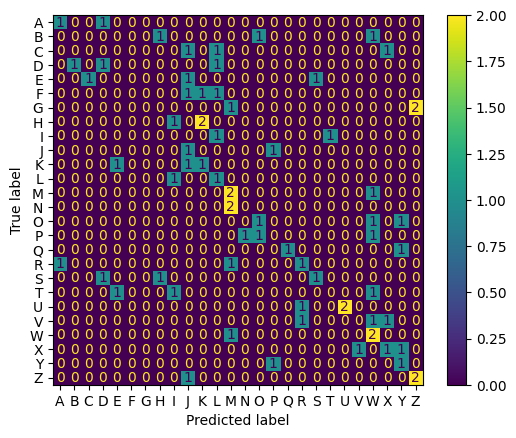

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


rfc_model = RandomForestClassifier(max_depth=6, random_state=42)
rfc_model.fit(list(X_train), Y_train)
rfc_model_prediction = rfc_model.predict(list(X_test))
print("Score: " + str(metrics.accuracy_score(Y_test, rfc_model_prediction) * 100))
    
disp = metrics.ConfusionMatrixDisplay.from_predictions(Y_test, rfc_model_prediction)
plt.show()

# 6. Fine Tune the Model
- All fine tuning was done in the above cells, not shown, but easily replicable.
- To fine tune each model, I tried several different values for the parameters that affect each model.
1. For MLP, I looped through 625 different values for the first hidden layer size. I then looped through 377 values for the second hidden layer size maintaining the first layer size, and finally looped through 235 values for the third hidden layer size maintaining the previous layer sizes. I found that 2 hidden layers with 377 and 235 nodes respectively gave the highest accuracy.
2. For SVC, I tried all the different kernel options. I found that linear and poly both got the same accuracy, so I chose linear.
3. For K-Nearest, I looped through 20 different n_neighbors values and found that 1, the lowest, was the best.
4. For Random Forest Classifier, I looped through 50 different max_depth values, finding that 6/7 was the best.

# 7. Present the solution
- First, I imported my data and organized/converted all the files to be organized and easily accessible.
- Then, I looked through all the pictures to figure out what changes had to be made (cropping, resizing, binarizing, etc)
- Then, I created a process that every image goes through to clean it using these observed changes, and saved the cleaned images to a new folder.
- Then, I flattened the images and put them into a dataframe.
- Then, I split the data into a test and train set, and then tried fitting 4 different models to see which would give the highest accuracy.
- Then, I decided on the model that gave the best accuracy and had the best confusion matrix.
- Finally, I deployed the chosen model to a file for usage elsewhere and created a function for easy access.
#### THE CHOSEN MODEL WAS K-NEAREST NEIGHBORS

# 8. Launch the Model System

In [8]:
import pickle

pickle.dump(knearest_model, open('knearest_model.pkl', 'wb'))

- To use the deployment function below, run the cell and input the file path of a picture you want to test.

In [ ]:
import pickle
import cv2
import numpy as np

def predict(filePath):
    knearest_model_loaded = pickle.load(open('knearest_model.pkl', 'rb'))

    image = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE) #bgr to rgb is req for correct colors to show
    image = cv2.resize(image, (25,25))
    predicted_letter = knearest_model_loaded.predict([np.array(image).flatten()])

    print("The predicted cursive letter is: " + str(predicted_letter[0]))
    return(predicted_letter)

# predict(input("Input the file path to the image: "))


for folder in sorted(os.listdir("2023_Cursive_Cleaned")):
    for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
        predict("2023_Cursive_Cleaned/" + folder + "/" + letter + ".JPG")


#2023_Cursive_Cleaned/1/A.JPG

today i learned that the sunk cost fallacy is a real thing. the hard way.